In [1]:
import json as json
import os
import pathlib as pl
from datetime import datetime
from gc import collect
from os import mkdir, path, system

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from numpy import array, meshgrid, ones
from numpy.linalg import norm
from PIL import Image
from scipy.spatial.transform import Rotation
from tqdm import tqdm

from calc_catenary_from_ext_points import get_coor_marker_points_ideal_catenary

gain = 1.5
rcParams[ 'figure.figsize' ] = [ gain * 6.4, gain * 4.8 / 2 ]

In [2]:
for v in pl.Path( "./plots" ).glob( '*' ):
	if datetime.fromtimestamp( path.getctime( v ) ).date() >= datetime.fromisocalendar( 2024, 37, 2 ).date():
		print( str( v ).split( '_' )[ -1 ], end = '\t' )
		print( datetime.fromtimestamp( path.getctime( v ) ), end = '\t' )
		try:
			record = pd.read_csv( f'{v}/logs.txt', sep = '\t' ).shape[ 0 ]
			with open( f'{v}/config.json' ) as f:
				conf = json.load( f )
		except:
			print( 'unable to read' )
		planned = array( conf[ 'target_trajectory' ] ).shape[ 0 ] // 2
		print( f'{record=}\t{planned=}\t{record == planned}' )

1724851485	2024-09-12 22:05:01.437115	record=399	planned=12	False
1725264976	2024-09-12 22:05:01.853236	record=299	planned=300	False
1725268112	2024-09-12 22:05:01.928170	record=299	planned=300	False
1725274451	2024-09-12 22:05:02.010784	record=299	planned=300	False
1725278516	2024-09-12 22:05:02.088836	record=299	planned=300	False
1725525073	2024-09-12 22:05:02.166874	record=599	planned=600	False
1725534896	2024-09-12 22:05:02.353150	record=599	planned=600	False
1726033948	2024-09-11 07:52:28.967991	record=2000	planned=2000	True
1726033954	2024-09-12 22:05:02.508750	record=2000	planned=2000	True
1726033959	2024-09-12 22:05:02.522252	record=2000	planned=2000	True
1726151643	2024-09-12 16:34:03.025139	record=2000	planned=2000	True
1726153404	2024-09-12 17:03:24.524985	record=2000	planned=2000	True
1726157070	2024-09-12 18:04:30.478803	record=2000	planned=2000	True
1726240678	2024-09-13 17:17:58.406534	record=53	planned=2000	False
1726240752	2024-09-13 17:19:12.269375	unable to read
reco

In [3]:
folder = pl.Path( './plots/three_robots_chain_with_fixed_end_1726242029' )
data = pd.read_csv( f'{folder}/logs.txt', sep = '\t' )
with open( f'{folder}/config.json' ) as f:
	conf = json.load( f )
data[ 'time' ] = [ i * conf[ 'time_step' ] for i in data.index ]

In [4]:
def disp( d: dict, prefix: str = '' ):
	for k, v in d.items():

		if isinstance( v, dict ):
			print( prefix + k + ':' )
			disp( v, prefix + '\t' )
			continue

		if isinstance( v, list ):
			if len( v ) > 0 and isinstance( v[ 0 ], dict ):
				print( prefix + k + ':' )
				disp( { str( i ): e for i, e in enumerate( v ) }, prefix + '\t' )
				continue

			l = array( v ).shape
			print( prefix + k + ':', v if sum( l ) < 10 else l )
			continue

		print( prefix + k + ':', v )


disp( conf )

model_dynamics: three_robots_chain_with_fixed_end
time_step: 0.01
kwargs:
	weight: [0.0, 0.0, 112.81500000000001]
	buoyancy: [0.0, 0.0, -120.0]
	center_of_mass: [0.0, 0.0, 0.0]
	center_of_volume: [0.0, 0.0, -0.02]
	inverted_inertial_matrix: (6, 6)
	hydrodynamic_matrix: (6, 6)
state: (48,)
actuation: (18,)
record: True
previous_states: (1, 48)
previous_actuations: (1, 18)
model: None
horizon: 25
target_trajectory: (4000, 1, 24)
objective: three_robot_chain_objective
time_steps_per_actuation: 25
guess_from_last_solution: True
tolerance: 0.0001
max_iter: 1000
bounds:
	lb: (18,)
	ub: (18,)
	keep_feasible: (18,)
constraints:
	0:
		fun: constraint_f
		lb: (300,)
		ub: (300,)
		finite_diff_rel_step: None
		finite_diff_jac_sparsity: None
		jac: 2-point
		hess: None
		keep_feasible: False
result_shape: [1, 1, 18]
raw_result: None
result: (1, 1, 18)
pose_weight_matrix: (25, 24, 24)
actuation_derivative_weight_matrix: (1, 18, 18)
objective_weight: 10.0
final_weight: 10.0
predicted_trajectories: [

In [5]:
conf[ 'constraints' ][ 0 ][ 'ub' ][ :len( conf[ 'constraints' ][ 0 ][ 'ub' ] ) // 25 ]

[3.00001, 3.00001, 3.00001, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 3.0, 3.0, 3.0]

In [6]:
conf[ 'constraints' ][ 0 ][ ('lb') ][ :len( conf[ 'constraints' ][ 0 ][ 'ub' ] ) // 25 ]

[-inf, -inf, -inf, 0.4, 0.4, 0.4, -inf, -inf, -inf, -inf, -inf, -inf]

In [7]:
data.tail( 10 )

,index,sim_time,step_time,success,C01,C12,C23,D01,D12,D23,...,speed_r0,speed_r1,speed_r2,speed_r3,actuation_r0,actuation_r1,actuation_r2,objective,Unnamed: 25,time
1990,1990,4488.983907,0.464525,True,0.974374,1.639061,1.447893,1.353667,1.031294,0.882493,...,"[0.03445046937884004, 0.004591576980244419, -0...","[-0.1435048370955795, 0.3453688411601091, 0.13...","[-0.11975726312381495, 0.1814213474047094, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-3.288591398661503, -3.689969014124458, 6.845...","[-39.069012856627936, -34.27807109436858, 74.9...","[-87.3335400090584, 57.007754723913486, 45.136...",5.152990,NaN,19.90
1991,1991,4489.613426,0.581692,True,0.973154,1.640490,1.445299,1.354804,1.029944,0.883909,...,"[0.03181420652844262, 0.0018116556253812604, -...","[-0.16128145883584194, 0.29998731947522866, 0....","[-0.1889728723492883, 0.22069999937693874, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-3.1588938784117007, -3.2173171418171282, 6.9...","[-19.82962454686728, -54.19956698069874, 54.99...","[-78.97696925989136, 43.92288310520935, 64.427...",5.046772,NaN,19.91
1992,1992,4490.601662,0.943824,True,0.971565,1.641973,1.441389,1.356240,1.028625,0.885399,...,"[0.029281959530154136, -0.0005715701625127276,...","[-0.16236118082317913, 0.23698979001656287, 0....","[-0.2511527230616347, 0.24878286880002537, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-3.029196358161898, -2.7446652695097984, 6.95...","[-0.5902362371066232, -74.12106286702891, 34.9...","[-70.62039851072433, 30.838011486505216, 83.71...",5.522044,NaN,19.92
1993,1993,4491.231835,0.577499,True,0.969769,1.643593,1.436290,1.357840,1.027379,0.886892,...,"[0.026854115280579145, -0.0025559195734737314,...","[-0.1466853941163872, 0.1562807192556903, 0.21...","[-0.3062721040496285, 0.26560924158469496, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-2.8994952056598153, -2.2719841849480154, 7.0...","[18.649151439654084, -94.04254644433541, 14.99...","[-62.26381851794047, 17.75313540187167, 103.01...",6.527968,NaN,19.93
1994,1994,4491.680694,0.399644,True,0.967933,1.645431,1.430129,1.359462,1.026250,0.888315,...,"[0.02453105753083836, -0.004139224022871728, -...","[-0.11419528361077702, 0.05776404423637119, 0....","[-0.3543062228965444, 0.2711180774825924, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-2.7697940531577325, -1.7993031003862323, 7.0...","[37.88853911641479, -113.96403002164192, -5.00...","[-53.907238525156615, 4.668259317238125, 122.3...",7.933742,NaN,19.94
1995,1995,4494.841380,3.118339,True,0.966215,1.647542,1.423097,1.360972,1.025275,0.889600,...,"[0.022314214244886263, -0.005314052984367592, ...","[-0.06887634764215195, -0.0478949588828055, 0....","[-0.3896134724123834, 0.26478201614794294, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-2.6388940906214233, -1.3206022341595092, 7.1...","[52.48487396473473, -121.5428130397978, -22.95...","[-39.10273554571649, -8.951055353798843, 127.7...",8.044749,NaN,19.95
1996,1996,4497.317668,2.434608,True,0.964755,1.649965,1.415450,1.362254,1.024478,0.890685,...,"[0.020204751462190924, -0.006075627327932658, ...","[-0.018480594885236845, -0.1438793895329071, 0...","[-0.41084121726248435, 0.2468395767302588, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-2.5070999532969607, -0.8389704337574531, 7.1...","[58.130315594531844, -109.78997892982044, -35....","[-22.796728188754614, -22.223145807173417, 128...",7.622831,NaN,19.96
1997,1997,4500.900128,3.540401,True,0.963661,1.652708,1.407499,1.363219,1.023858,0.891531,...,"[0.018213631354891128, -0.006408279233365004, ...","[0.03407407513086601, -0.22498943962160167, 0....","[-0.41472221573588836, 0.2202326417456149, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-2.3631682906451927, -0.3419514700072584, 7.2...","[60.405594341415714, -92.13368743154167, -44.8...","[-2.796728188754617, -32.049026483941134, 110....",6.598322,NaN,19.97
1998,1998,4501.319623,0.374027,True,0.963035,1.655746,1.399586,1.363784,1.023410,0.892115,...,"[0.016341282381157906, -0.006309674442360901, ...","[0.08879523137307463, -0.

In [8]:
state_r0 = data[ 'state_r0' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
state_r1 = data[ 'state_r1' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
state_r2 = data[ 'state_r2' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
state_r3 = data[ 'state_r3' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)

speed_r0 = data[ 'speed_r0' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
speed_r0[ 'l_norm' ] = norm( speed_r0[ [ 'x', 'y', 'z' ] ], axis = 1 )
speed_r0[ 'a_norm' ] = norm( speed_r0[ [ 'phi', 'theta', 'psi' ] ], axis = 1 )

speed_r1 = data[ 'speed_r1' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
speed_r1[ 'l_norm' ] = norm( speed_r1[ [ 'x', 'y', 'z' ] ], axis = 1 )
speed_r1[ 'a_norm' ] = norm( speed_r1[ [ 'phi', 'theta', 'psi' ] ], axis = 1 )

speed_r2 = data[ 'speed_r2' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
speed_r2[ 'l_norm' ] = norm( speed_r2[ [ 'x', 'y', 'z' ] ], axis = 1 )
speed_r2[ 'a_norm' ] = norm( speed_r2[ [ 'phi', 'theta', 'psi' ] ], axis = 1 )

speed_r3 = data[ 'speed_r3' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
speed_r3[ 'l_norm' ] = norm( speed_r3[ [ 'x', 'y', 'z' ] ], axis = 1 )
speed_r3[ 'a_norm' ] = norm( speed_r3[ [ 'phi', 'theta', 'psi' ] ], axis = 1 )

actuation_r0 = data[ 'actuation_r0' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
actuation_r1 = data[ 'actuation_r1' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
actuation_r2 = data[ 'actuation_r2' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)

n_frames = len( conf[ 'target_trajectory' ] )
traj = array( conf[ 'target_trajectory' ] )[ :n_frames // 2, :, : ]

# Errors

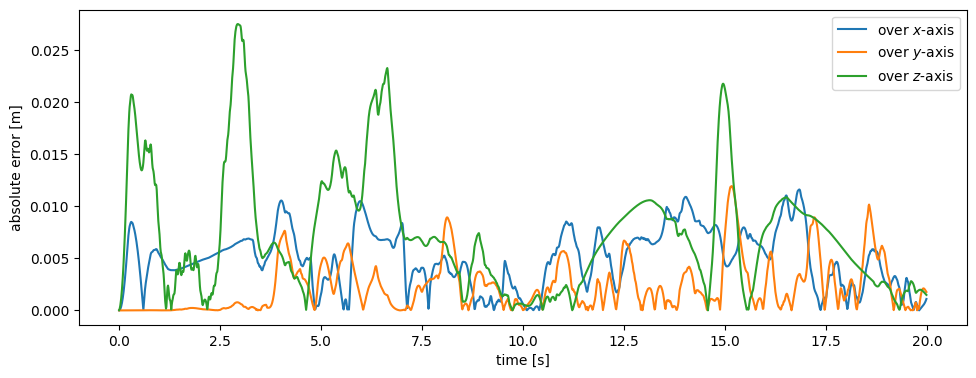

In [9]:
plt.plot( data[ 'time' ], abs( traj[ :data.shape[ 0 ], 0, :3 ] - state_r0[ [ 'x', 'y', 'z' ] ] ) )
plt.legend( [ 'over $x$-axis', 'over $y$-axis', 'over $z$-axis' ] )
plt.xlabel( 'time [s]' )
plt.ylabel( 'absolute error [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/error.png', dpi = 300 )

In [10]:
(abs( traj[ :data.shape[ 0 ], 0, :3 ] - state_r0[ [ 'x', 'y', 'z' ] ] )).describe()

,x,y,z
count,2.000000e+03,2.000000e+03,2000.000000
mean,4.954273e-03,2.288528e-03,0.007348
std,2.788889e-03,2.426962e-03,0.005802
min,7.628425e-09,7.040716e-16,0.000003
25%,2.909853e-03,3.281062e-04,0.002722
50%,4.925700e-03,1.591912e-03,0.006408
75%,6.850241e-03,3.402313e-03,0.010026
max,1.160438e-02,1.193189e-02,0.027484


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >]], dtype=object)

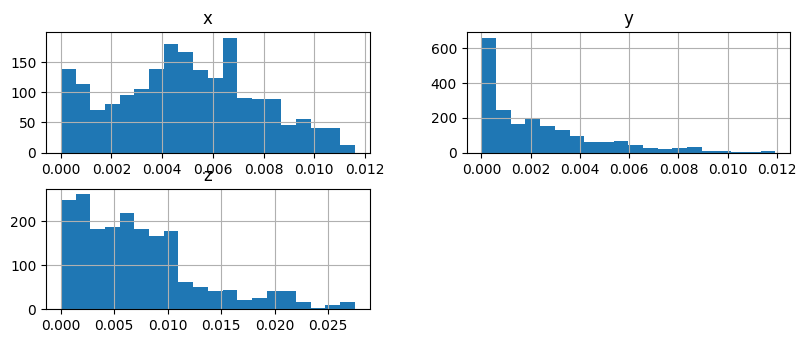

In [11]:
(abs( traj[ :data.shape[ 0 ], 0, :3 ] - state_r0[ [ 'x', 'y', 'z' ] ] )).hist( bins = 20 )

<Axes: >

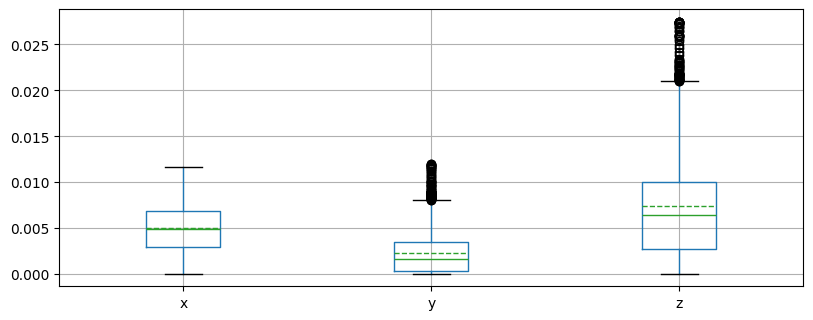

In [12]:
(abs( traj[ :data.shape[ 0 ], 0, :3 ] - state_r0[ [ 'x', 'y', 'z' ] ] )).boxplot( meanline = True, showmeans = True )

In [13]:
pd.DataFrame( norm( traj[ :data.shape[ 0 ], 0, :3 ] - state_r0[ [ 'x', 'y', 'z' ] ], axis = 1 ) ).describe()

,0
count,2000.000000
mean,0.010027
std,0.005529
min,0.000031
25%,0.005974
50%,0.009015
75%,0.012955
max,0.028253


array([[<Axes: title={'center': '0'}>]], dtype=object)

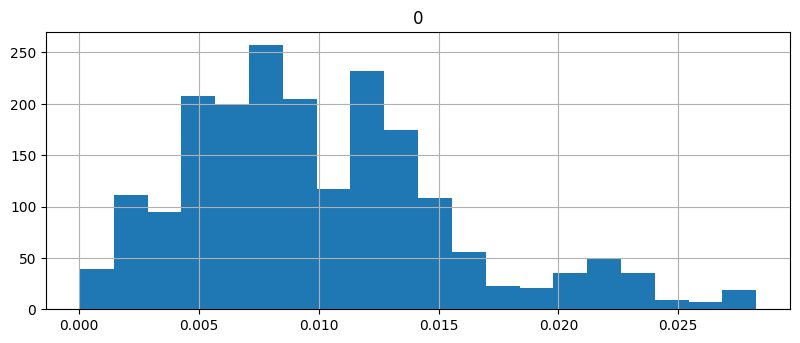

In [14]:
pd.DataFrame( norm( traj[ :data.shape[ 0 ], 0, :3 ] - state_r0[ [ 'x', 'y', 'z' ] ], axis = 1 ) ).hist( bins = 20 )

<Axes: >

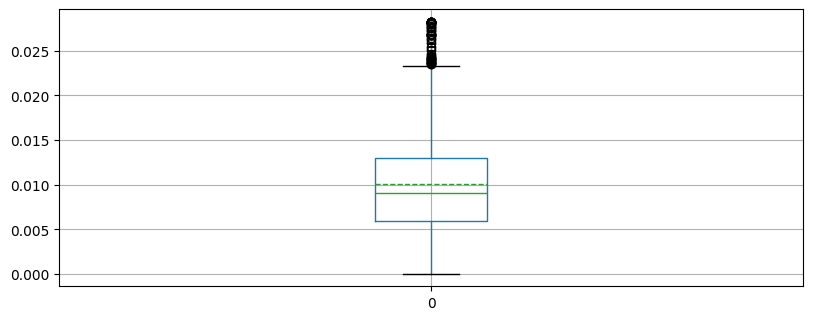

In [15]:
pd.DataFrame( norm( traj[ :data.shape[ 0 ], 0, :3 ] - state_r0[ [ 'x', 'y', 'z' ] ], axis = 1 ) ).boxplot(
		meanline = True,
		showmeans = True
		)

# Constraints

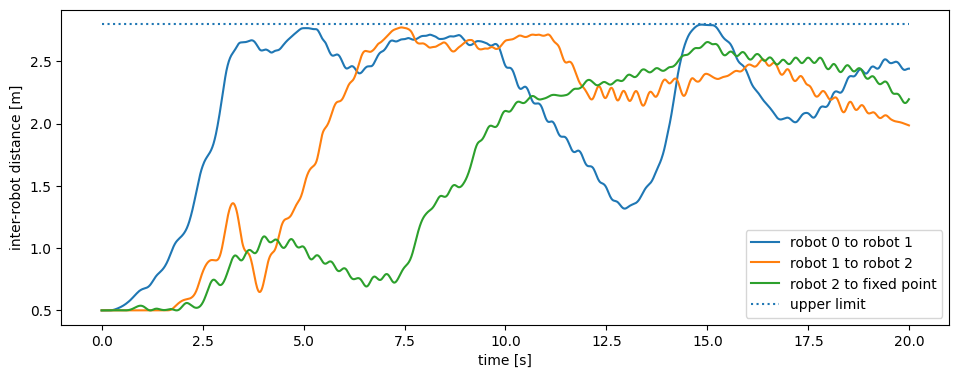

In [38]:
plt.plot( data[ 'time' ], norm( state_r1[ [ 'x', 'y', 'z' ] ] - state_r0[ [ 'x', 'y', 'z' ] ], axis = 1 ) )
plt.plot( data[ 'time' ], norm( state_r2[ [ 'x', 'y', 'z' ] ] - state_r1[ [ 'x', 'y', 'z' ] ], axis = 1 ) )
plt.plot( data[ 'time' ], norm( state_r3[ [ 'x', 'y', 'z' ] ] - state_r2[ [ 'x', 'y', 'z' ] ], axis = 1 ) )
plt.hlines( conf[ 'constraints' ][ 0 ][ 'ub' ][ 4 ], 0, data[ 'time' ].max(), linestyles = ':' )
plt.legend( [ 'robot 0 to robot 1', 'robot 1 to robot 2', 'robot 2 to fixed point', 'upper limit' ] )
plt.xlabel( 'time [s]' )
plt.ylabel( 'inter-robot distance [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/inter_robot_distance.png', dpi = 300 )

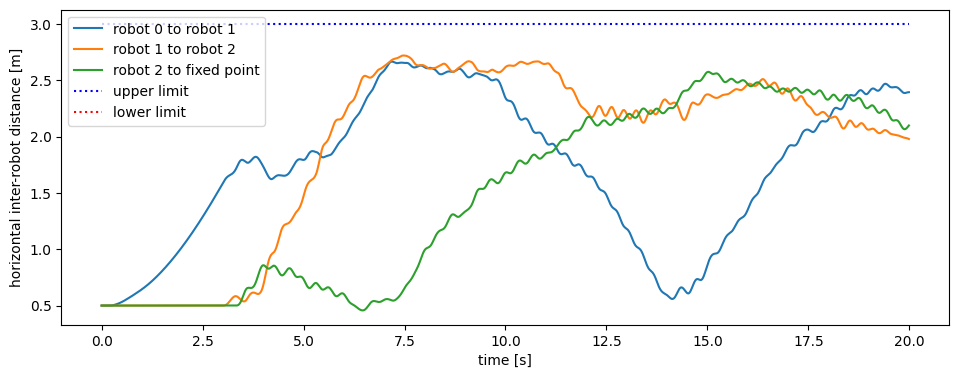

In [39]:
plt.plot( data[ 'time' ], norm( state_r1[ [ 'x', 'y' ] ] - state_r0[ [ 'x', 'y' ] ], axis = 1 ) )
plt.plot( data[ 'time' ], norm( state_r2[ [ 'x', 'y' ] ] - state_r1[ [ 'x', 'y' ] ], axis = 1 ) )
plt.plot( data[ 'time' ], norm( state_r3[ [ 'x', 'y' ] ] - state_r2[ [ 'x', 'y' ] ], axis = 1 ) )
plt.hlines( conf[ 'constraints' ][ 0 ][ 'ub' ][ 2 ], 0, data[ 'time' ].max(), linestyles = ':', color = 'b' )
plt.hlines( conf[ 'constraints' ][ 0 ][ 'lb' ][ 2 ], 0, data[ 'time' ].max(), linestyles = ':', color = 'r' )
plt.legend( [ 'robot 0 to robot 1', 'robot 1 to robot 2', 'robot 2 to fixed point', 'upper limit', 'lower limit' ] )
plt.xlabel( 'time [s]' )
plt.ylabel( 'horizontal inter-robot distance [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/horizontal_inter_robot_distance.png', dpi = 300 )

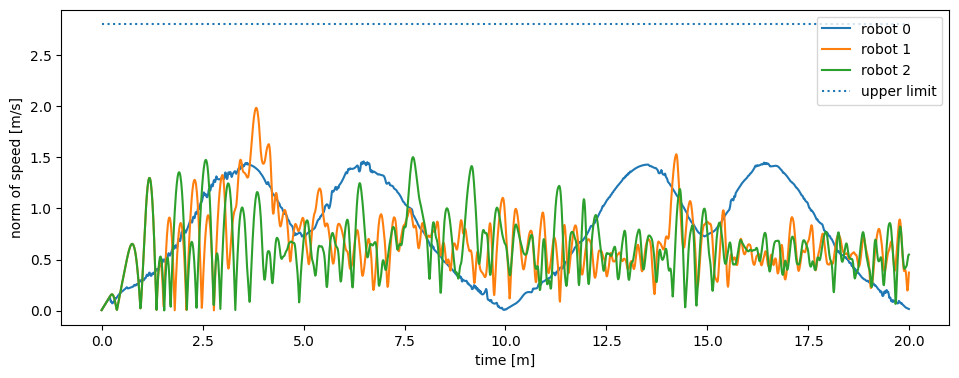

In [18]:
plt.plot( data[ 'time' ], speed_r0[ 'l_norm' ] )
plt.plot( data[ 'time' ], speed_r1[ 'l_norm' ] )
plt.plot( data[ 'time' ], speed_r2[ 'l_norm' ] )
plt.hlines( conf[ 'constraints' ][ 0 ][ 'ub' ][ 6 ], 0, data[ 'time' ].max(), linestyles = ':' )
plt.legend( [ 'robot 0', 'robot 1', 'robot 2', 'upper limit' ] )
plt.xlabel( 'time [m]' )
plt.ylabel( 'norm of speed [m/s]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/robots_speed.png', dpi = 300 )

# States

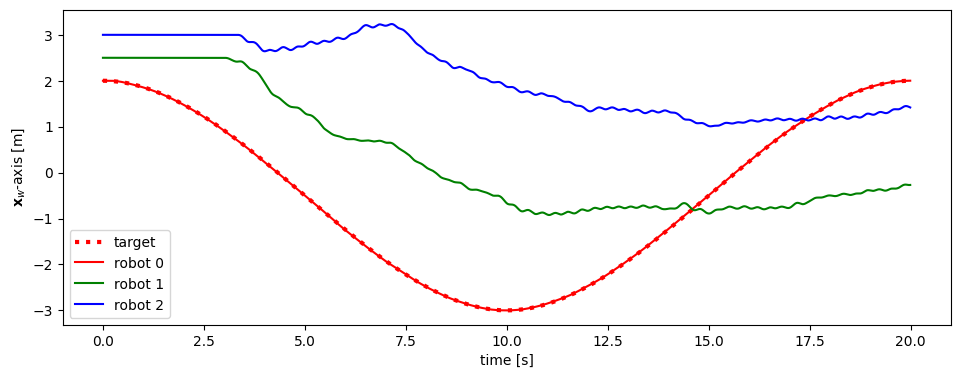

In [46]:
try:
	plt.plot( data[ 'time' ], traj[ :, 0, 0 ], ':', color = 'r', linewidth = 3 )
except:
	pass
plt.plot( data[ 'time' ], state_r0[ 'x' ], 'r' )
plt.plot( data[ 'time' ], state_r1[ 'x' ], 'g' )
plt.plot( data[ 'time' ], state_r2[ 'x' ], 'b' )

plt.legend( [ 'target', 'robot 0', 'robot 1', 'robot 2' ] )
plt.xlabel( 'time [s]' )
plt.ylabel( r'$\mathbf{x}_w$-axis [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/pose_x.png', dpi = 300 )

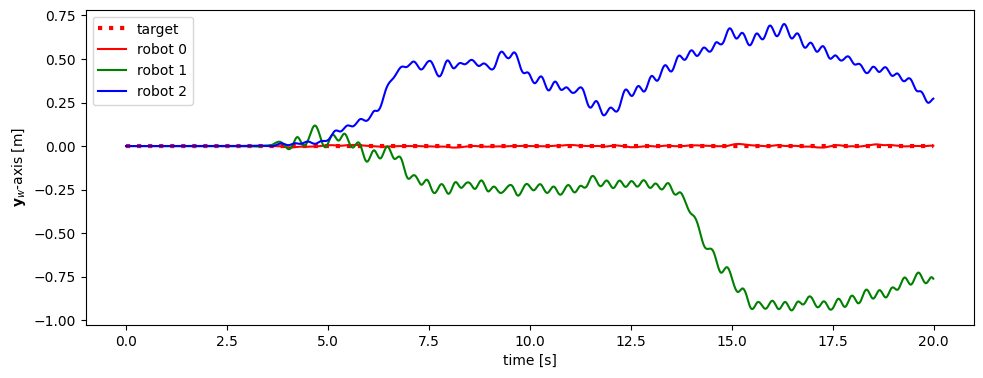

In [47]:
try:
	plt.plot( data[ 'time' ], traj[ :, 0, 1 ], ':', color = 'r', linewidth = 3 )
except:
	pass
plt.plot( data[ 'time' ], state_r0[ 'y' ], 'r' )
plt.plot( data[ 'time' ], state_r1[ 'y' ], 'g' )
plt.plot( data[ 'time' ], state_r2[ 'y' ], 'b' )

plt.legend( [ 'target', 'robot 0', 'robot 1', 'robot 2' ] )
plt.xlabel( 'time [s]' )
plt.ylabel( r'$\mathbf{y}_w$-axis [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/pose_y.png', dpi = 300 )

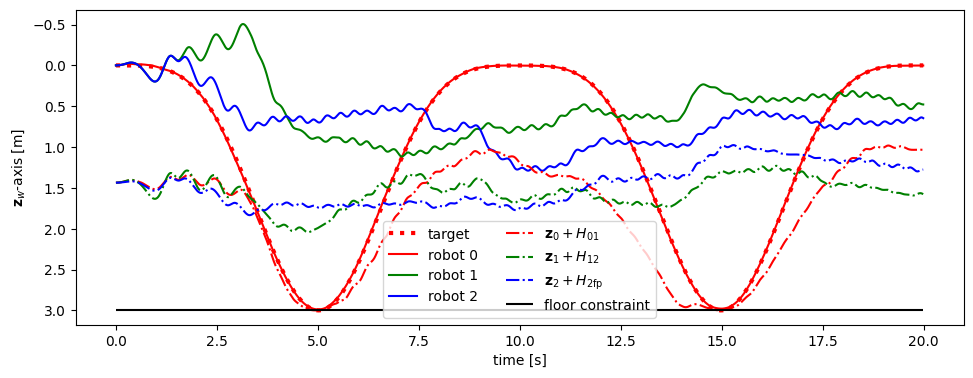

In [48]:
try:
	plt.plot( data[ 'time' ], traj[ :, 0, 2 ], ':', color = 'r', linewidth = 3 )
except:
	pass
plt.plot( data[ 'time' ], state_r0[ 'z' ], 'r' )
plt.plot( data[ 'time' ], state_r1[ 'z' ], 'g' )
plt.plot( data[ 'time' ], state_r2[ 'z' ], 'b' )
plt.plot( data[ 'time' ], data[ 'H01' ] + state_r0[ 'z' ], '-.', color = 'r' )
plt.plot( data[ 'time' ], data[ 'H12' ] + state_r1[ 'z' ], '-.', color = 'g' )
plt.plot( data[ 'time' ], data[ 'H23' ] + state_r2[ 'z' ], '-.', color = 'b' )

plt.hlines( conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ], 0, data[ 'time' ].max(), 'k' )
plt.legend(
		[ 'target', 'robot 0', 'robot 1', 'robot 2', r'$\mathbf{z}_0 + H_{01}$', r'$\mathbf{z}_1 + H_{12}$', r'$\mathbf{z}_2 + H_{2\text{fp}}$',
			'floor constraint' ],
		ncol = 2
		)
plt.gca().invert_yaxis()
plt.xlabel( 'time [s]' )
plt.ylabel( r'$\mathbf{z}_w$-axis [m]' )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/pose_z.png', dpi = 300 )

# Speeds

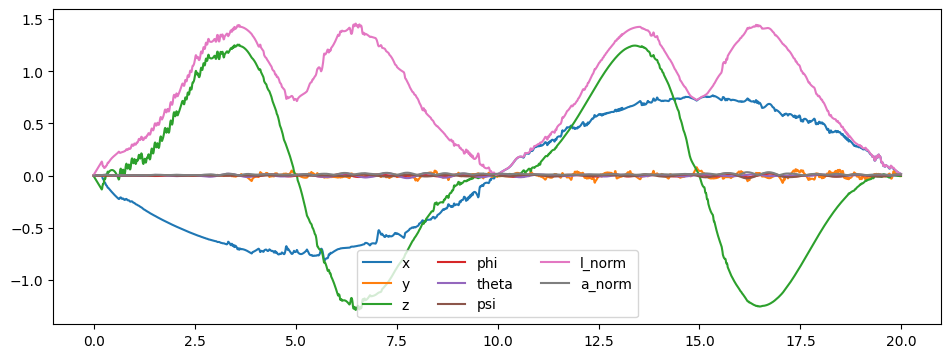

In [22]:
plt.plot( data[ 'time' ], speed_r0 )
plt.legend( speed_r0.columns, ncol = 3 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/speed_r0.png', dpi = 300 )

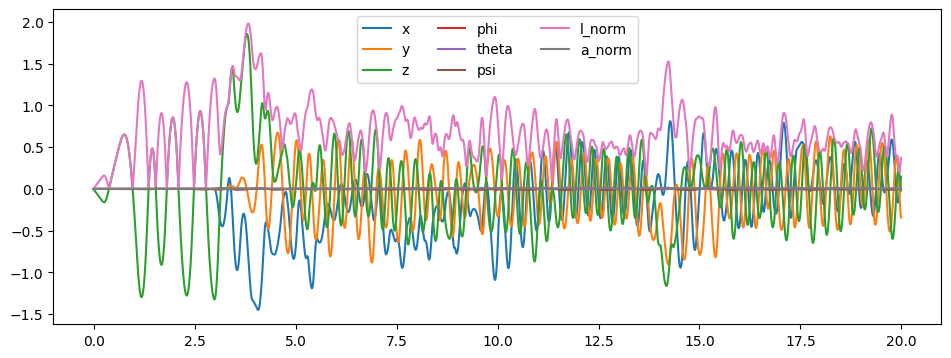

In [23]:
plt.plot( data[ 'time' ], speed_r1 )
plt.legend( speed_r1.columns, ncol = 3 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/speed_r1.png', dpi = 300 )

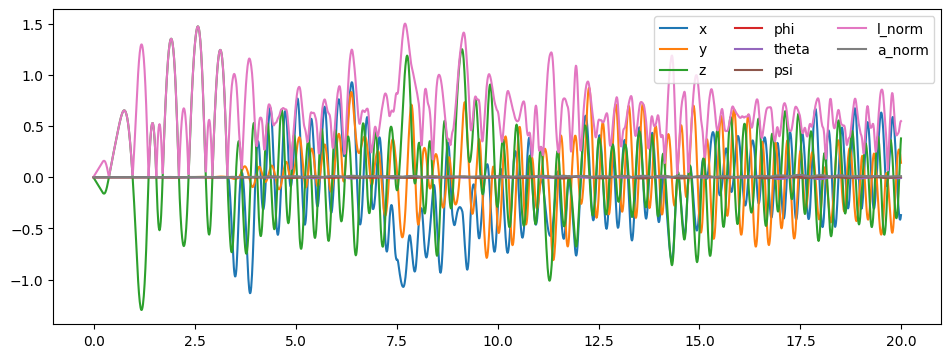

In [24]:
plt.plot( data[ 'time' ], speed_r2 )
plt.legend( speed_r2.columns, ncol = 3 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/speed_r2.png', dpi = 300 )

# Actuations

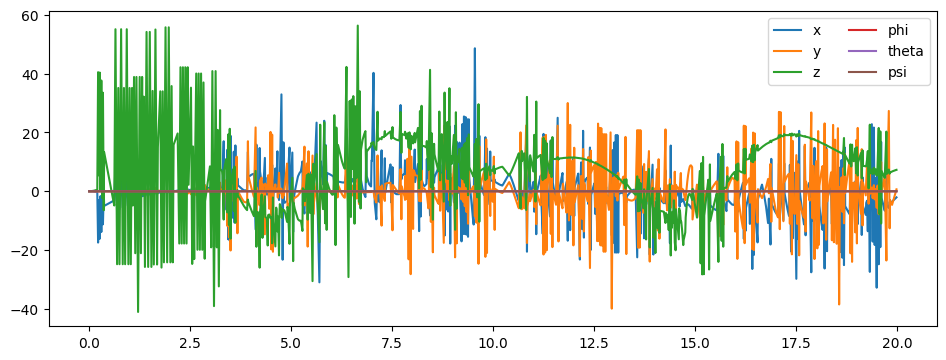

In [25]:
plt.plot( data[ 'time' ], actuation_r0 )
plt.legend( actuation_r0.columns, ncol = 2 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/actuation_r0.png', dpi = 300 )

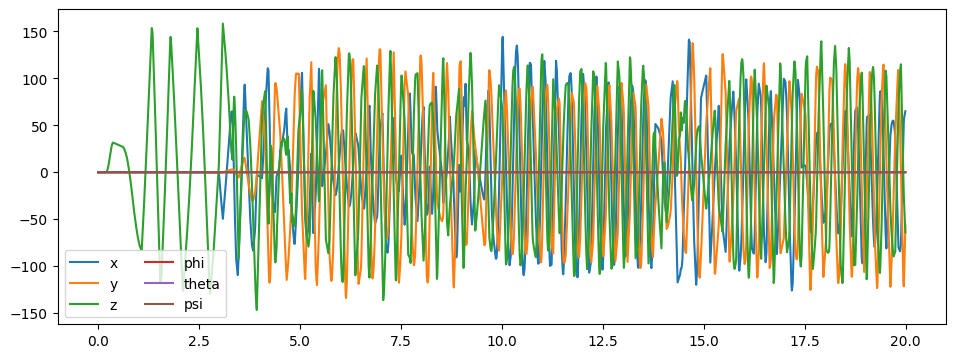

In [26]:
plt.plot( data[ 'time' ], actuation_r1 )
plt.legend( actuation_r1.columns, ncol = 2 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/actuation_r1.png', dpi = 300 )

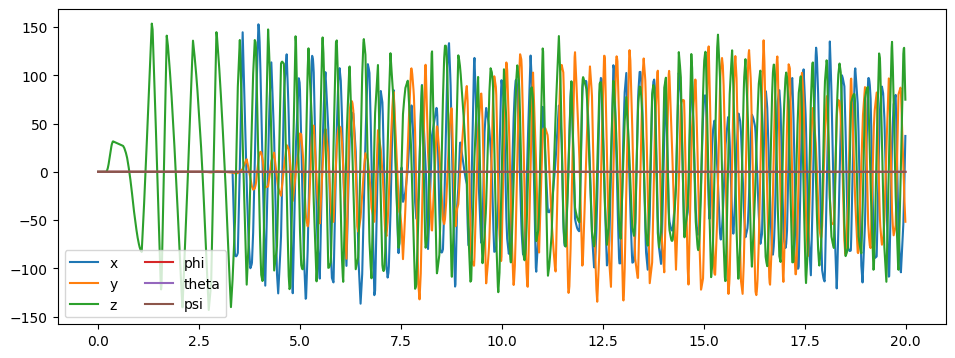

In [27]:
plt.plot( data[ 'time' ], actuation_r2 )
plt.legend( actuation_r2.columns, ncol = 2 )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/actuation_r2.png', dpi = 300 )

# Time

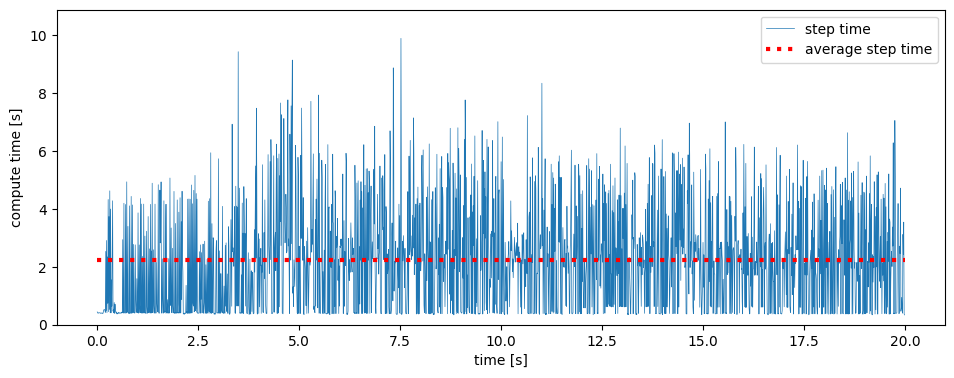

In [28]:
plt.plot( data[ 'time' ], data[ 'step_time' ], linewidth = .5 )
plt.hlines( data.step_time.mean(), 0, data[ 'time' ].max(), linestyles = ':', color = 'r', linewidth = 3 )
plt.ylabel( 'compute time [s]' )
plt.xlabel( 'time [s]' )
plt.gca().set_ylim( 0, data.step_time.max() * 1.1 )
plt.legend( [ 'step time', 'average step time' ] )
plt.subplots_adjust( bottom = 0.125, top = 1, left = 0.075, right = 1 )
plt.savefig( f'{folder}/compute_time.png', dpi = 300 )

In [29]:
data[ 'step_time' ].describe()

count    2000.000000
mean        2.226180
std         1.839842
min         0.339243
25%         0.408533
50%         2.034797
75%         3.286654
max         9.882522
Name: step_time, dtype: float64

<Axes: >

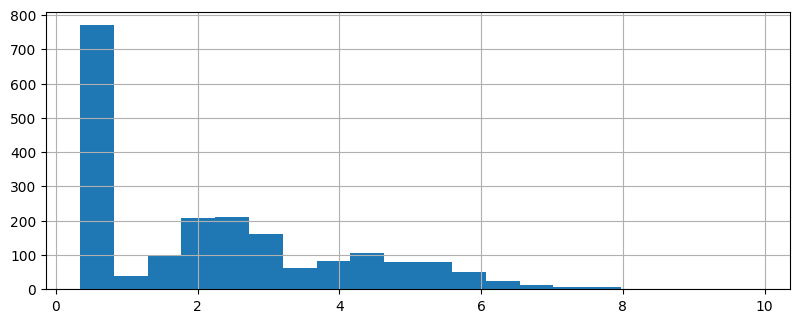

In [30]:
data[ 'step_time' ].hist( bins = 20 )

<Axes: >

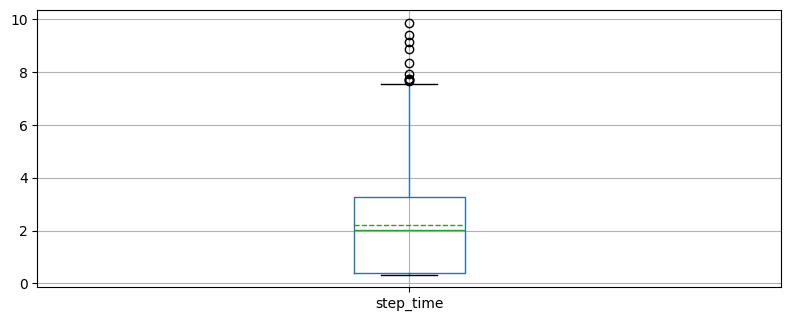

In [31]:
data[ 'step_time' ].to_frame().boxplot( meanline = True, showmeans = True )

In [ ]:
if not path.exists( f'{folder}/anim' ):
	mkdir( f'{folder}/anim' )
else:
	files_in_dir = list( pl.Path( f'{folder}/anim' ).glob( '*' ) )
	if len( files_in_dir ) > 0:
		if input( f"{folder} contains data. Remove? (y/n) " ) == 'y':
			for fig in files_in_dir:
				os.remove( fig )

for i in tqdm( range( data.shape[ 0 ] ) ):
	volume = array( [ [ -3.5, 3.5 ], [ -3.5, 3.5 ], [ -2, 5 ] ] )
	fig = plt.figure( figsize = (10, 10) )
	view = plt.subplot( projection = '3d' )
	view.set_xlabel( "x" )
	view.set_ylabel( "y" )
	view.set_zlabel( "z" )
	view.set_xlim( *volume[ 0 ] )
	view.set_ylim( *volume[ 1 ] )
	view.set_zlim( *volume[ 2 ] )
	view.invert_yaxis()
	view.invert_zaxis()

	inset_view_xz = view.inset_axes( [ .0, .0, .2, .2 ] )
	inset_view_xz.set_xlabel( "x" )
	inset_view_xz.set_ylabel( "z" )
	inset_view_xz.set_xlim( *volume[ 0 ] )
	inset_view_xz.set_ylim( *volume[ 2 ] )
	inset_view_xz.invert_yaxis()

	inset_view_yz = view.inset_axes( [ .8, .0, .2, .2 ] )
	inset_view_yz.set_xlabel( "y" )
	inset_view_yz.set_ylabel( "z" )
	inset_view_yz.set_xlim( *volume[ 1 ] )
	inset_view_yz.set_ylim( *volume[ 2 ] )
	inset_view_yz.invert_xaxis()
	inset_view_yz.invert_yaxis()

	inset_view_xy = view.inset_axes( [ .0, .8, .2, .2 ] )
	inset_view_xy.set_xlabel( "x" )
	inset_view_xy.set_ylabel( "y" )
	inset_view_xy.set_xlim( *volume[ 0 ] )
	inset_view_xy.set_ylim( *volume[ 1 ] )
	inset_view_xy.invert_yaxis()

	target_trajectory = array( conf[ 'target_trajectory' ] )[ :, 0, : ]

	surf_x = [ volume[ 0 ][ 0 ], volume[ 0 ][ 1 ] ]
	surf_y = volume[ 1 ]
	surf_x, surf_y = meshgrid( surf_x, surf_y )
	surf_z = ones( surf_x.shape ) * conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ]
	view.plot_surface( surf_x, surf_y, surf_z, alpha = 0.1 )
	inset_view_xz.plot(
			[ volume[ 0 ][ 0 ], volume[ 0 ][ 1 ] ],
			[ conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ], conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ] ]
			)
	inset_view_yz.plot(
			[ volume[ 1 ][ 0 ], volume[ 1 ][ 1 ] ],
			[ conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ], conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ] ]
			)

	target_pose = target_trajectory[ i ]

	r0 = Rotation.from_euler( 'xyz', state_r0.iloc[ i ].to_numpy()[ 3:6 ] ).as_matrix()
	r1 = Rotation.from_euler( 'xyz', state_r1.iloc[ i ].to_numpy()[ 3:6 ] ).as_matrix()
	r2 = Rotation.from_euler( 'xyz', state_r2.iloc[ i ].to_numpy()[ 3:6 ] ).as_matrix()
	r3 = Rotation.from_euler( 'xyz', state_r3.iloc[ i ].to_numpy()[ 3:6 ] ).as_matrix()
	r0t = Rotation.from_euler( 'xyz', target_pose[ 3:6 ] ).as_matrix()

	quiver_scale = .25
	view.quiver(
			*state_r0.iloc[ i ].to_numpy()[ :3 ], *(r0 @ (quiver_scale * array( [ 1., 0., 0. ] ))),
			color = 'blue'
			)
	view.quiver(
			*state_r1.iloc[ i ].to_numpy()[ :3 ], *(r1 @ (quiver_scale * array( [ 1., 0., 0. ] ))),
			color = 'red'
			)
	view.quiver(
			*state_r2.iloc[ i ].to_numpy()[ :3 ],
			*(r2 @ (quiver_scale * array( [ 1., 0., 0. ] ))),
			color = 'green'
			)
	view.quiver(
			*state_r3.iloc[ i ].to_numpy()[ :3 ],
			*(r3 @ (quiver_scale * array( [ 1., 0., 0. ] ))),
			color = 'green'
			)
	view.quiver(
			*target_pose[ :3 ], *(r0t @ (quiver_scale * array( [ 1., 0., 0. ] ))), color = 'black'
			)

	inset_view_xz.scatter( state_r0.iloc[ i ].to_numpy()[ 0 ], state_r0.iloc[ i ].to_numpy()[ 2 ], color = 'blue' )
	inset_view_xz.scatter( state_r1.iloc[ i ].to_numpy()[ 0 ], state_r1.iloc[ i ].to_numpy()[ 2 ], color = 'red' )
	inset_view_xz.scatter( state_r2.iloc[ i ].to_numpy()[ 0 ], state_r2.iloc[ i ].to_numpy()[ 2 ], color = 'green' )
	inset_view_xz.scatter( state_r3.iloc[ i ].to_numpy()[ 0 ], state_r3.iloc[ i ].to_numpy()[ 2 ], color = 'yellow' )

	inset_view_yz.scatter( state_r0.iloc[ i ].to_numpy()[ 1 ], state_r0.iloc[ i ].to_numpy()[ 2 ], color = 'blue' )
	inset_view_yz.scatter( state_r1.iloc[ i ].to_numpy()[ 1 ], state_r1.iloc[ i ].to_numpy()[ 2 ], color = 'red' )
	inset_view_yz.scatter( state_r2.iloc[ i ].to_numpy()[ 1 ], state_r2.iloc[ i ].to_numpy()[ 2 ], color = 'green' )
	inset_view_yz.scatter( state_r3.iloc[ i ].to_numpy()[ 1 ], state_r3.iloc[ i ].to_numpy()[ 2 ], color = 'yellow' )

	inset_view_xy.scatter( state_r0.iloc[ i ].to_numpy()[ 0 ], state_r0.iloc[ i ].to_numpy()[ 1 ], color = 'blue' )
	inset_view_xy.scatter( state_r1.iloc[ i ].to_numpy()[ 0 ], state_r1.iloc[ i ].to_numpy()[ 1 ], color = 'red' )
	inset_view_xy.scatter( state_r2.iloc[ i ].to_numpy()[ 0 ], state_r2.iloc[ i ].to_numpy()[ 1 ], color = 'green' )
	inset_view_xy.scatter( state_r3.iloc[ i ].to_numpy()[ 0 ], state_r3.iloc[ i ].to_numpy()[ 1 ], color = 'yellow' )

	view.plot(
			state_r0[ 'x' ].to_numpy()[ :i ],
			state_r0[ 'y' ].to_numpy()[ :i ],
			state_r0[ 'z' ].to_numpy()[ :i ],
			color = 'blue'
			)
	view.plot(
			state_r1[ 'x' ].to_numpy()[ :i ],
			state_r1[ 'y' ].to_numpy()[ :i ],
			state_r1[ 'z' ].to_numpy()[ :i ],
			color = 'red'
			)
	view.plot(
			state_r2[ 'x' ].to_numpy()[ :i ],
			state_r2[ 'y' ].to_numpy()[ :i ],
			state_r2[ 'z' ].to_numpy()[ :i ],
			color = 'green'
			)
	view.plot(
			state_r3[ 'x' ].to_numpy()[ :i ],
			state_r3[ 'y' ].to_numpy()[ :i ],
			state_r3[ 'z' ].to_numpy()[ :i ],
			color = 'yellow'
			)

	inset_view_xz.plot(
			state_r0.iloc[ i ].to_numpy()[ 0 ], state_r0.iloc[ i ].to_numpy()[ 2 ], color = 'blue'
			)
	inset_view_xz.plot(
			state_r1.iloc[ i ].to_numpy()[ 0 ], state_r1.iloc[ i ].to_numpy()[ 2 ], color = 'red'
			)
	inset_view_xz.plot(
			state_r2.iloc[ i ].to_numpy()[ 0 ], state_r2.iloc[ i ].to_numpy()[ 2 ], color = 'green'
			)
	inset_view_xz.plot(
			state_r3.iloc[ i ].to_numpy()[ 0 ], state_r3.iloc[ i ].to_numpy()[ 2 ], color = 'yellow'
			)

	inset_view_yz.plot(
			state_r0.iloc[ i ].to_numpy()[ 1 ], state_r0.iloc[ i ].to_numpy()[ 2 ], color = 'blue'
			)
	inset_view_yz.plot(
			state_r1.iloc[ i ].to_numpy()[ 1 ], state_r1.iloc[ i ].to_numpy()[ 2 ], color = 'red'
			)
	inset_view_yz.plot(
			state_r2.iloc[ i ].to_numpy()[ 1 ], state_r2.iloc[ i ].to_numpy()[ 2 ], color = 'green'
			)
	inset_view_yz.plot(
			state_r3.iloc[ i ].to_numpy()[ 1 ], state_r3.iloc[ i ].to_numpy()[ 2 ], color = 'yellow'
			)

	inset_view_xy.plot(
			state_r0.iloc[ i ].to_numpy()[ 0 ], state_r0.iloc[ i ].to_numpy()[ 1 ], color = 'blue'
			)
	inset_view_xy.plot(
			state_r1.iloc[ i ].to_numpy()[ 0 ], state_r1.iloc[ i ].to_numpy()[ 1 ], color = 'red'
			)
	inset_view_xy.plot(
			state_r2.iloc[ i ].to_numpy()[ 0 ], state_r2.iloc[ i ].to_numpy()[ 1 ], color = 'green'
			)
	inset_view_xy.plot(
			state_r3.iloc[ i ].to_numpy()[ 0 ], state_r3.iloc[ i ].to_numpy()[ 1 ], color = 'yellow'
			)

	view.plot( target_trajectory[ :, 0 ], target_trajectory[ :, 1 ], target_trajectory[ :, 2 ], ':' )
	inset_view_xz.plot( target_trajectory[ :, 0 ], target_trajectory[ :, 2 ], ':' )
	inset_view_yz.plot( target_trajectory[ :, 1 ], target_trajectory[ :, 2 ], ':' )
	inset_view_xy.plot( target_trajectory[ :, 0 ], target_trajectory[ :, 1 ], ':' )

	try:
		cat01, _, _, H01 = get_coor_marker_points_ideal_catenary(
				state_r0.iloc[ i ].to_numpy()[ 0 ],
				-state_r0.iloc[ i ].to_numpy()[ 1 ],
				-state_r0.iloc[ i ].to_numpy()[ 2 ],
				state_r1.iloc[ i ].to_numpy()[ 0 ],
				-state_r1.iloc[ i ].to_numpy()[ 1 ],
				-state_r1.iloc[ i ].to_numpy()[ 2 ],
				3.,
				.2
				)
		cat12, _, _, H12 = get_coor_marker_points_ideal_catenary(
				state_r1.iloc[ i ].to_numpy()[ 0 ],
				-state_r1.iloc[ i ].to_numpy()[ 1 ],
				-state_r1.iloc[ i ].to_numpy()[ 2 ],
				state_r2.iloc[ i ].to_numpy()[ 0 ],
				-state_r2.iloc[ i ].to_numpy()[ 1 ],
				-state_r2.iloc[ i ].to_numpy()[ 2 ],
				3.,
				.2
				)
		cat23, _, _, H23 = get_coor_marker_points_ideal_catenary(
				state_r2.iloc[ i ].to_numpy()[ 0 ],
				-state_r2.iloc[ i ].to_numpy()[ 1 ],
				-state_r2.iloc[ i ].to_numpy()[ 2 ],
				state_r3.iloc[ i ].to_numpy()[ 0 ],
				-state_r3.iloc[ i ].to_numpy()[ 1 ],
				-state_r3.iloc[ i ].to_numpy()[ 2 ],
				3.,
				.2
				)
		cat01[ :, 1: ] *= -1
		cat12[ :, 1: ] *= -1
		cat23[ :, 1: ] *= -1
	except:
		cat01 = array( [ state_r0.iloc[ i ].to_numpy()[ :3 ], state_r1.iloc[ i ].to_numpy()[ :3 ] ] )
		cat12 = array( [ state_r1.iloc[ i ].to_numpy()[ :3 ], state_r2.iloc[ i ].to_numpy()[ :3 ] ] )
		cat23 = array( [ state_r2.iloc[ i ].to_numpy()[ :3 ], state_r3.iloc[ i ].to_numpy()[ :3 ] ] )
		H01 = None
		H12 = None
		H23 = None

	view.plot( cat01[ :, 0 ], cat01[ :, 1 ], cat01[ :, 2 ], 'blue' )
	view.plot( cat12[ :, 0 ], cat12[ :, 1 ], cat12[ :, 2 ], 'red' )
	view.plot( cat23[ :, 0 ], cat23[ :, 1 ], cat23[ :, 2 ], 'green' )

	inset_view_xz.plot( cat01[ :, 0 ], cat01[ :, 2 ], 'blue' )
	inset_view_xz.plot( cat12[ :, 0 ], cat12[ :, 2 ], 'red' )
	inset_view_xz.plot( cat23[ :, 0 ], cat23[ :, 2 ], 'green' )
	inset_view_yz.plot( cat01[ :, 1 ], cat01[ :, 2 ], 'blue' )
	inset_view_yz.plot( cat12[ :, 1 ], cat12[ :, 2 ], 'red' )
	inset_view_yz.plot( cat23[ :, 1 ], cat23[ :, 2 ], 'green' )
	inset_view_xy.plot( cat01[ :, 0 ], cat01[ :, 1 ], 'blue' )
	inset_view_xy.plot( cat12[ :, 0 ], cat12[ :, 1 ], 'red' )
	inset_view_xy.plot( cat23[ :, 0 ], cat23[ :, 1 ], 'green' )

	plt.savefig( f'{folder}/anim/{i}.png', dpi = 100 )
	plt.close( 'all' )
	del fig

In [35]:
collect()

27536243

In [33]:
names = [ image for image in pl.Path( f"{folder}/anim" ).glob( "*.png" ) ]
print( len( names ) )
names.sort( key = lambda x: path.getmtime( x ) )
frames = [ Image.open( name ) for name in names ]
frame_one = frames[ 0 ]
frame_one.save(
		f"{folder}/anim/animation.gif", append_images = frames, loop = True, save_all = True
		)

2000


In [34]:
system( f'ffmpeg -itsscale 0.25 -i {folder}/anim/animation.gif {folder}/anim/video.mp4' )

0